In [1]:
import gym
from matplotlib import pyplot as plt
import time
import numpy as np
import scipy
import cv2
from IPython import display
import scipy.optimize
%matplotlib inline

In [141]:
# ACTIONS
FULL_AHEAD = np.array([0, .5, 0])
HALF_AHEAD = np.array([0, 0.075, 0])
FULL_LEFT = np.array([-1, 0.075, 0])
FULL_RIGHT = np.array([1, 0.075, 0])
NULL_ACTION = np.array([0, 0, 0])

# PIXELS
LIGHT_GREEN = [100, 228, 100]
DARK_GREEN = [100, 228, 100]
ROAD = [100, 100, 100]

In [3]:
env = gym.make("CarRacing-v2", new_step_api=True)
env.action_space.seed(42)
def reset_env():
    observation, info = env.reset(seed=42, return_info=True)
    for _ in range(50):
        observation, _, _, _, _ = env.step(NULL_ACTION)
        
    return observation
_ = reset_env()

In [4]:
def distance_to_colour(patch, colour):
    return np.linalg.norm(patch - colour, axis=-1)

In [5]:
# API
env.action_space

Box([-1.  0.  0.], 1.0, (3,), float32)

In [6]:
#### RANDOM JUST FORWARD
reset_env()
for i in range(50):
    observation, reward, done, info, _ = env.step([0, 100, 0])
    if done:
        reset_env()
#     observation, reward, done, info, _ = env.step(env.action_space.sample())
    if i % 3 ==0:
#         plt.imshow(observation)
        env.render()
#         display.display(plt.gcf())
#         display.clear_output(wait=True)

/home/hannes/miniconda3/envs/race/lib/python3.10/site-packages/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [157]:
#### AMAZING AI
def get_actionv1(obervation):
    
    def middle_ahead_is_road():
        middle = observation[0, 48, :]
        return np.linalg.norm(ROAD - middle) < 10
    if middle_ahead_is_road():
        return FULL_AHEAD

def get_actionv2(obervation):
    def middle_ahead_is_road():
        middle = observation[25, 48, :]
        return np.linalg.norm(ROAD - middle) < 10
    
    if middle_ahead_is_road():
        return HALF_AHEAD, "middle_ahead_is_road"
    return FULL_LEFT, "DEFAULT"

def get_actionv3(obervation):
    def middle_ahead_is_road():
        middle = observation[25, 48, :]
        return np.linalg.norm(ROAD - middle) < 10
    
    def get_near_road_direction():
        near_left = obervation[40:70, 48 - 18: 48]
        near_right = obervation[40:70, 48:48 + 18]
        if False:
            fig, axs = plt.subplots(ncols=2)
            axs[0].imshow(near_left)
            axs[1].imshow(near_right)
            plt.show()
        left_road = (distance_to_colour(near_left, ROAD) < 10).mean()
        right_road = (distance_to_colour(near_right, ROAD) < 10).mean()
        action = None
        if right_road > left_road:
            action = FULL_RIGHT
            description = "more_road_on_right"
            magnitude = right_road / (right_road + left_road + 1)
        if left_road > right_road:
            action = FULL_LEFT
            description = "more_road_on_left"
            magnitude = left_road / (right_road + left_road + 1)
        if action is not None:
            action = action.copy()
            action[0] *= magnitude
            print("Magnitude", magnitude)
            return action, description
        return FULL_AHEAD, "equal_both_sides"
        
    #if middle_ahead_is_road():
    #    return HALF_AHEAD, "middle_ahead_is_road"
    
    return get_near_road_direction()
    return FULL_LEFT, "DEFAULT"

def get_actionv4(obervation):
    def middle_ahead_is_road():
        middle = observation[25, 48, :]
        return np.linalg.norm(ROAD - middle) < 10
    
    def get_near_road_direction():
        near_left = obervation[40:70, 48 - 18: 48]
        near_right = obervation[40:70, 48:48 + 18]
        if False:
            fig, axs = plt.subplots(ncols=2)
            axs[0].imshow(near_left)
            axs[1].imshow(near_right)
            plt.show()
        left_road = (distance_to_colour(near_left, ROAD) < 10).mean()
        right_road = (distance_to_colour(near_right, ROAD) < 10).mean()
        action = None
        steering = right_road / (right_road + left_road + 1)

        if action is not None:
            action = action.copy()
            action[0] = steering
            print("Magnitude", magnitude)
            return action, description
        return FULL_AHEAD, "equal_both_sides"
        
    #if middle_ahead_is_road():
    #    return HALF_AHEAD, "middle_ahead_is_road"
    
    return get_near_road_direction()
    return FULL_LEFT, "DEFAULT"

get_action = get_actionv3

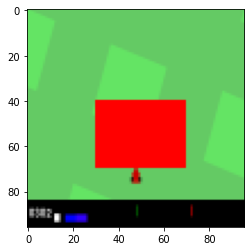

In [158]:

obs_copy = observation.copy()
obs_copy[40:70, 30: 70] = [255, 0, 0]
plt.imshow(obs_copy)

In [153]:
from simple_pid import PID

In [154]:
# PID v1: 
# pid = PID(1, 0.1, 0.05)

In [161]:
pid = PID(1, 0.1, 0.05)
observation = reset_env()

In [162]:
#### AMAZING AI functions
#observation = reset_env()

for i in range(3000):
    action, action_name = get_action(observation)
    action = action.copy()
    print(action[0])
    if np.isnan(action[0]):
        print("DERPDERP")
    pid_action = -pid(action[0])
    action[0] = pid_action
    print("PID:", pid_action)
    
    print(action_name)
    observation, reward, done, info, _ = env.step(action)
    if done:
        observation = reset_env()
    
    env.render()
#         plt.imshow(observation)
#         display.display(plt.gcf())
#         display.clear_output(wait=True)
#     if i % 3 ==0:

Magnitude 0.27589285714285716
0.27589285714285716
PID: 0.2891645926807769
more_road_on_right
Magnitude 0.27589285714285716
0.27589285714285716
PID: 0.2896940150443402
more_road_on_right
Magnitude 0.27589285714285716
0.27589285714285716
PID: 0.2903353478274523
more_road_on_right
Magnitude 0.2774308652988403
0.2774308652988403
PID: 0.2965814661485526
more_road_on_right
Magnitude 0.2774308652988403
0.2774308652988403
PID: 0.29300978776946573
more_road_on_right
Magnitude 0.2761394101876676
0.2761394101876676
PID: 0.28978992126098385
more_road_on_right
Magnitude 0.27515583259127335
0.27515583259127335
PID: 0.28988223173667005
more_road_on_right
Magnitude 0.27386262265834077
0.27386262265834077
PID: 0.2885778040372234
more_road_on_right
Magnitude 0.27248441674087265
0.27248441674087265
PID: 0.2871430843077389
more_road_on_right
Magnitude 0.2669642857142857
0.2669642857142857
PID: 0.27267901524513777
more_road_on_right
Magnitude 0.26028622540250446
0.26028622540250446
PID: 0.26181216614474956

Magnitude 0.27882037533512066
0.27882037533512066
PID: 0.2708557342559686
more_road_on_right
Magnitude 0.25958965209634255
0.25958965209634255
PID: 0.23408414321204868
more_road_on_right
Magnitude 0.2664884135472371
-0.2664884135472371
PID: -1.5870365457283189
more_road_on_left
Magnitude 0.2792149866190901
-0.2792149866190901
PID: -0.28880781955494345
more_road_on_left
Magnitude 0.29233511586452765
-0.29233511586452765
PID: -0.3029337700465897
more_road_on_left
Magnitude 0.3021390374331551
-0.3021390374331551
PID: -0.3100528720805388
more_road_on_left
Magnitude 0.30899376669634904
-0.30899376669634904
PID: -0.30810769913104047
more_road_on_left
Magnitude 0.3119429590017826
-0.3119429590017826
PID: -0.3029461878640963
more_road_on_left
Magnitude 0.3134461264470169
-0.3134461264470169
PID: -0.3025287702233326
more_road_on_left
Magnitude 0.31016042780748665
-0.31016042780748665
PID: -0.28820065150391994
more_road_on_left
Magnitude 0.3038427167113495
-0.3038427167113495
PID: -0.27502247373

Magnitude 0.3321554770318021
0.3321554770318021
PID: 0.3785214864938381
more_road_on_right
Magnitude 0.33835252435783875
0.33835252435783875
PID: 0.36477684817999806
more_road_on_right
Magnitude 0.3410097431355182
0.3410097431355182
PID: 0.3592291426985543
more_road_on_right
Magnitude 0.34012400354295835
0.34012400354295835
PID: 0.35025571428675634
more_road_on_right
Magnitude 0.33126110124333924
0.33126110124333924
PID: 0.32231485765683593
more_road_on_right
Magnitude 0.31850533807829184
0.31850533807829184
PID: 0.304168045052617
more_road_on_right
Magnitude 0.3003565062388592
0.3003565062388592
PID: 0.27836978040827187
more_road_on_right
Magnitude 0.2863514719000892
0.2863514719000892
PID: 0.266317549312225
more_road_on_right
Magnitude 0.25958965209634255
0.25958965209634255
PID: 0.21426510739909718
more_road_on_right
Magnitude 0.2798573975044564
-0.2798573975044564
PID: -1.3902434802961472
more_road_on_left
Magnitude 0.29946524064171126
-0.29946524064171126
PID: -0.33517082134726534

Magnitude 0.33333333333333337
0.33333333333333337
PID: 0.3664540554962816
more_road_on_right
Magnitude 0.3493333333333334
0.3493333333333334
PID: 0.3809053878796559
more_road_on_right
Magnitude 0.36049601417183347
0.36049601417183347
PID: 0.37704316315439584
more_road_on_right
Magnitude 0.3643617021276596
0.3643617021276596
PID: 0.36266981373508184
more_road_on_right
Magnitude 0.3643617021276596
0.3643617021276596
PID: 0.3539565077561624
more_road_on_right
Magnitude 0.3558718861209964
0.3558718861209964
PID: 0.32553428405213936
more_road_on_right
Magnitude 0.3428317008014248
0.3428317008014248
PID: 0.301576588867215
more_road_on_right
Magnitude 0.3247100802854594
0.3247100802854594
PID: 0.2730203857692739
more_road_on_right
Magnitude 0.31003584229390685
0.31003584229390685
PID: 0.2675999823347171
more_road_on_right
Magnitude 0.27807486631016043
0.27807486631016043
PID: 0.19547834409623388
more_road_on_right
Magnitude 0.2653606411398041
-0.2653606411398041
PID: -1.6090863495177932
more_

Magnitude 0.29385574354407834
0.29385574354407834
PID: 0.23467030944748735
more_road_on_right
Magnitude 0.26803205699020477
0.26803205699020477
PID: 0.20729111408989986
more_road_on_right
Magnitude 0.2783687943262411
-0.2783687943262411
PID: -1.4247803889123445
more_road_on_left
Magnitude 0.308303886925795
-0.308303886925795
PID: -0.38812498418291885
more_road_on_left
Magnitude 0.33480176211453744
-0.33480176211453744
PID: -0.4072519348512071
more_road_on_left
Magnitude 0.3563922942206655
-0.3563922942206655
PID: -0.41357164298751764
more_road_on_left
Magnitude 0.37237762237762234
-0.37237762237762234
PID: -0.4195274188173156
more_road_on_left
Magnitude 0.3851528384279476
-0.3851528384279476
PID: -0.4235565413783351
more_road_on_left
Magnitude 0.3902012248468941
-0.3902012248468941
PID: -0.4112127560098014
more_road_on_left
Magnitude 0.3894736842105263
-0.3894736842105263
PID: -0.39678029844190443
more_road_on_left
Magnitude 0.3800705467372134
-0.3800705467372134
PID: -0.36741107689031

Magnitude 0.38481675392670156
-0.38481675392670156
PID: -0.42832079882717156
more_road_on_left
Magnitude 0.39510489510489505
-0.39510489510489505
PID: -0.4256463356055383
more_road_on_left
Magnitude 0.3991266375545852
-0.3991266375545852
PID: -0.4140098357569683
more_road_on_left
Magnitude 0.3973684210526316
-0.3973684210526316
PID: -0.3990306922421357
more_road_on_left
Magnitude 0.3901581722319859
-0.3901581722319859
PID: -0.37907335695330596
more_road_on_left
Magnitude 0.3748894783377542
-0.3748894783377542
PID: -0.3443787024862264
more_road_on_left
Magnitude 0.3561887800534283
-0.3561887800534283
PID: -0.3173393519928609
more_road_on_left
Magnitude 0.3321396598030439
-0.3321396598030439
PID: -0.28126157663383927
more_road_on_left
Magnitude 0.31222123104371097
-0.31222123104371097
PID: -0.27212419500549107
more_road_on_left
Magnitude 0.2792149866190901
-0.2792149866190901
PID: -0.20746270336828965
more_road_on_left
Magnitude 0.2745792736935341
0.2745792736935341
PID: 1.60645091715152

Magnitude 0.31523642732049034
-0.31523642732049034
PID: -0.40003785308168316
more_road_on_left
Magnitude 0.3443766346992153
-0.3443766346992153
PID: -0.42067874216475637
more_road_on_left
Magnitude 0.3703382480485689
-0.3703382480485689
PID: -0.4402648440046353
more_road_on_left
Magnitude 0.3868169991326973
-0.3868169991326973
PID: -0.4335999040340764
more_road_on_left
Magnitude 0.3989547038327526
-0.3989547038327526
PID: -0.43704585375985666
more_road_on_left
Magnitude 0.40436681222707427
-0.40436681222707427
PID: -0.42549825632172716
more_road_on_left
Magnitude 0.4040315512708151
-0.4040315512708151
PID: -0.4120399079460577
more_road_on_left
Magnitude 0.3970201577563541
-0.3970201577563541
PID: -0.38970377178232707
more_road_on_left
Magnitude 0.3851590106007067
-0.3851590106007067
PID: -0.3663601650760388
more_road_on_left
Magnitude 0.36645962732919257
-0.36645962732919257
PID: -0.33226088992101316
more_road_on_left
Magnitude 0.3443060498220641
-0.3443060498220641
PID: -0.29836093966

Magnitude 0.3856041131105398
0.3856041131105398
PID: 0.426652512642293
more_road_on_right
Magnitude 0.4031277150304084
0.4031277150304084
PID: 0.4245769571508253
more_road_on_right
Magnitude 0.41212653778558866
0.41212653778558866
PID: 0.4122636015837845
more_road_on_right
Magnitude 0.42053571428571423
0.42053571428571423
PID: 0.4204604724365006
more_road_on_right
Magnitude 0.4250902527075812
0.4250902527075812
PID: 0.41620122329540865
more_road_on_right
Magnitude 0.4272644098810613
0.4272644098810613
PID: 0.41339277804038804
more_road_on_right
Magnitude 0.4317343173431734
0.4317343173431734
PID: 0.42371421837679385
more_road_on_right
Magnitude 0.4354688950789229
0.4354688950789229
PID: 0.42704914684956097
more_road_on_right
Magnitude 0.4398881640260951
0.4398881640260951
PID: 0.4338872822803038
more_road_on_right
Magnitude 0.4451672862453532
0.4451672862453532
PID: 0.44266799146847124
more_road_on_right
Magnitude 0.4506001846722068
0.4506001846722068
PID: 0.44871730885843647
more_road

Magnitude 0.4136722173531989
-0.4136722173531989
PID: -0.43445303678499186
more_road_on_left
Magnitude 0.4100087796312555
-0.4100087796312555
PID: -0.41523155743404
more_road_on_left
Magnitude 0.4089316987740806
-0.4089316987740806
PID: -0.4215194038873288
more_road_on_left
Magnitude 0.40769903762029747
-0.40769903762029747
PID: -0.42080358042448873
more_road_on_left
Magnitude 0.4045335658238884
-0.4045335658238884
PID: -0.41334910335437075
more_road_on_left
Magnitude 0.4008733624454149
-0.4008733624454149
PID: -0.40926887417685326
more_road_on_left
Magnitude 0.39792387543252594
-0.39792387543252594
PID: -0.40935202676485705
more_road_on_left
Magnitude 0.3944636678200692
-0.3944636678200692
PID: -0.40490829130319056
more_road_on_left
Magnitude 0.39013840830449825
-0.39013840830449825
PID: -0.39960207195401465
more_road_on_left
Magnitude 0.3836909871244635
-0.3836909871244635
PID: -0.3909198545816854
more_road_on_left
Magnitude 0.3753213367609255
-0.3753213367609255
PID: -0.381584017809

Magnitude 0.3261802575107296
-0.3261802575107296
PID: -0.4256309080798989
more_road_on_left
Magnitude 0.3555555555555555
-0.3555555555555555
PID: -0.4379952015958213
more_road_on_left
Magnitude 0.37682403433476397
-0.37682403433476397
PID: -0.4382079226514677
more_road_on_left
Magnitude 0.3946459412780657
-0.3946459412780657
PID: -0.4600721241251425
more_road_on_left
Magnitude 0.4060869565217391
-0.4060869565217391
PID: -0.4510620205478504
more_road_on_left
Magnitude 0.4120734908136483
-0.4120734908136483
PID: -0.4456959611697961
more_road_on_left
Magnitude 0.4165931156222419
-0.4165931156222419
PID: -0.4499552127997824
more_road_on_left
Magnitude 0.41666666666666674
-0.41666666666666674
PID: -0.43966747386063554
more_road_on_left
Magnitude 0.4171122994652407
-0.4171122994652407
PID: -0.44189349969250424
more_road_on_left
Magnitude 0.41666666666666674
-0.41666666666666674
PID: -0.4405589098549225
more_road_on_left
Magnitude 0.4193548387096775
-0.4193548387096775
PID: -0.451803510043164

Magnitude 0.2716049382716049
0.2716049382716049
PID: 1.6562903798744577
more_road_on_right
Magnitude 0.30971128608923887
0.30971128608923887
PID: 0.3531356715792612
more_road_on_right
Magnitude 0.34805194805194806
0.34805194805194806
PID: 0.3887059381955346
more_road_on_right
Magnitude 0.3799654576856649
0.3799654576856649
PID: 0.426887401154164
more_road_on_right
Magnitude 0.4039965247610774
0.4039965247610774
PID: 0.42330645028328917
more_road_on_right
Magnitude 0.4206836108676599
0.4206836108676599
PID: 0.42132530520110245
more_road_on_right
Magnitude 0.43097345132743364
0.43097345132743364
PID: 0.42561916051047066
more_road_on_right
Magnitude 0.43672014260249564
0.43672014260249564
PID: 0.41942944120149406
more_road_on_right
Magnitude 0.442256042972247
0.442256042972247
PID: 0.4254087477525965
more_road_on_right
Magnitude 0.4451438848920863
0.4451438848920863
PID: 0.4231532897963631
more_road_on_right
Magnitude 0.4475336322869955
0.4475336322869955
PID: 0.425064570974455
more_road_

Magnitude 0.35794960903562123
-0.35794960903562123
PID: -0.43444052836388775
more_road_on_left
Magnitude 0.37847222222222227
-0.37847222222222227
PID: -0.442344931102884
more_road_on_left
Magnitude 0.3909643788010426
-0.3909643788010426
PID: -0.43233116982313546
more_road_on_left
Magnitude 0.39790575916230364
-0.39790575916230364
PID: -0.4259208864435318
more_road_on_left
Magnitude 0.40017436791630334
-0.40017436791630334
PID: -0.42085399635531057
more_road_on_left
Magnitude 0.39561403508771925
-0.39561403508771925
PID: -0.40381204043648256
more_road_on_left
Magnitude 0.38373121131741816
-0.38373121131741816
PID: -0.37145653449097826
more_road_on_left
Magnitude 0.3673469387755102
-0.3673469387755102
PID: -0.3436859520099435
more_road_on_left
Magnitude 0.34581105169340465
-0.34581105169340465
PID: -0.3103218815385325
more_road_on_left
Magnitude 0.3250222617987533
-0.3250222617987533
PID: -0.29399393841386023
more_road_on_left
Magnitude 0.29669347631814125
-0.29669347631814125
PID: -0.24

Magnitude 0.425531914893617
0.425531914893617
PID: 0.4150120311924262
more_road_on_right
Magnitude 0.43983402489626555
0.43983402489626555
PID: 0.43903001701617983
more_road_on_right
Magnitude 0.45288753799392095
0.45288753799392095
PID: 0.44811453256798534
more_road_on_right
Magnitude 0.46640316205533594
0.46640316205533594
PID: 0.47044289814853724
more_road_on_right
Magnitude 0.48325358851674644
0.48325358851674644
PID: 0.4956318382370832
more_road_on_right
Magnitude 0.49162011173184356
0.49162011173184356
PID: 0.48368902578197526
more_road_on_right
Magnitude 0.4773550724637682
0.4773550724637682
PID: 0.41938431262371284
more_road_on_right
Magnitude 0.452930728241563
0.452930728241563
PID: 0.3795461081195027
more_road_on_right
Magnitude 0.42206654991243436
0.42206654991243436
PID: 0.3183563581485747
more_road_on_right
Magnitude 0.38965517241379316
0.38965517241379316
PID: 0.2845330383201414
more_road_on_right
Magnitude 0.3533389687235841
0.3533389687235841
PID: 0.23930620579191733
mo

0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
0.0
PID: -0.024355702162890618
equal_both_sides
Magnitude 0.005524861878453039
0.005524861878453039
PID: -0.005085670373933917
more_road_on_right
Magnitude 0.02702702702702703
0.02702702702702703
PID: 0.05693041648299137
more_road_on_right
Magnitude 0.059233449477351915
0.059233449477351915
PID: 0.1136961974732616
more_road_on_right
Magnitude 0.1044776119402985
0.1044776119402985
PID: 0.18270423403628885
more_road_on_rig

0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.02252060917268607
equal_both_sides
0.0
PID: -0.0

Magnitude 0.42263483642793986
-0.42263483642793986
PID: -0.43325806318278626
more_road_on_left
Magnitude 0.40049751243781095
-0.40049751243781095
PID: -0.37516265091920425
more_road_on_left
Magnitude 0.3616177636796193
-0.3616177636796193
PID: -0.2929938128724606
more_road_on_left
Magnitude 0.31439688715953307
-0.31439688715953307
PID: -0.23214046636362562
more_road_on_left
Magnitude 0.31913245546088304
0.31913245546088304
PID: 1.8057141446234664
more_road_on_right
Magnitude 0.36442687747035574
0.36442687747035574
PID: 0.4448983416102655
more_road_on_right
Magnitude 0.38512949039264827
0.38512949039264827
PID: 0.40828518654843426
more_road_on_right
Magnitude 0.3818350324374421
0.3818350324374421
PID: 0.34669114640739707
more_road_on_right
Magnitude 0.3472222222222222
0.3472222222222222
PID: 0.2365353337332045
more_road_on_right
Magnitude 0.3003708281829419
0.3003708281829419
PID: 0.15389622116479904
more_road_on_right
Magnitude 0.24861111111111112
0.24861111111111112
PID: 0.10309669605

0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_bot

0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_both_sides
0.0
PID: -0.024568691873416208
equal_bot

KeyboardInterrupt: 

In [ ]:
plt.imshow(observation)
plt.show()

In [7]:
def get_actionv1(obervation):
    if middle_ahead_is_road(observation):
        return FULL_THROTTLE

def get_actionv2(obervation):
    if middle_ahead_is_road(observation):
        return FULL_THROTTLE, "middle_ahead_is_road"
    return FULL_LEFT, "DEFAULT"
    
get_action = get_actionv2

In [8]:
# action functions

def pixel_is_road(pixel):
    np.linalg.norm(ROAD - middle) < 10

def middle_ahead_is_road(observation):
    middle = observation[0, 48, :]
    return pixel_is_road(middle)
    

In [9]:
observation = reset_env()
color_copy = observation.copy()

NameError: name 'reset_env' is not defined

In [10]:
def get_mask(observation):
    return np.linalg.norm(observation - ROAD, axis=-1) < 10

def objective(t, a, b, c, d):
    x = a * t + b
    y = c * t + d
    return x, y

def fit_curve(observation):
    mask = get_mask(observation)
    
    h, w, c = observation.shape
    w_coords, h_coords = np.meshgrid(np.arange(h), np.arange(w))
    out = np.vstack([h_coords[mask], w_coords[mask]])
    print(out)
    popt, _ = scipy.optimize.curve_fit(objective, range(out, (out[0,:], out[1,:])
    print(f"a={a}, b={b}, c={c}")
    return popt[0], popt[1], popt[2]

SyntaxError: '(' was never closed (2362074372.py, line 16)

In [11]:
observation = reset_env()
for i in range(185):
    observation, reward, done, info, _ = env.step(HALF_AHEAD)
    if done:
        observation = reset_env()
    
#     env.render()
#     print(i)
    plt.imshow(observation)
#     plt.show()
    

NameError: name 'reset_env' is not defined

In [12]:
sharp_left_curve = observation

NameError: name 'observation' is not defined

In [13]:
color_copy[0:2, 30:66, :] = 0
plt.imshow(color_copy)
plt.show()
# low_threshold  = 50
# high_threshold = 100
# plt.imshow(cv2.Canny(observation, low_threshold, high_threshold))

# mask = np.zeros((observation.shape[0], observation.shape[1]))
# mask = np.ma.masked_where(ar2%7,ar1)

# mask = np.linalg.norm(ROAD - observation)
# print(mask.shape)
# plt.imshow(mask)
# plt.show()

# print(out)


# x_values = [pixel for pixel in mask[mask==1]]
# positions=zip(*np.where(mask == 1))
# w_coord, y_coord
# print((positions.))
# y_values = [mask[1] for mask==1]
# y_values = 
# objective = 



    
a, b, c = fit_curve(sharp_left_curve)

x = range(96)
y = [objective(x, a, b, c) for x in range(96)]

fig, ax = plt.subplots()
ax.imshow(sharp_left_curve)
ax.plot(y, x, '--', linewidth=5, color='firebrick')


# plt.scatter(range(96), [objective(x, a, b) for x in range(96)])
# plt.xlim([0,96])
# plt.ylim([0,96])



NameError: name 'color_copy' is not defined

In [14]:
LIGHT_GREEN = [100, 228, 100]
DARK_GREEN = [100, 228, 100]
ROAD = [100, 100, 100]
left = observation[0, 30, :]
middle = observation[0, 48, :]
print("left: ", left)
print("middle: ", middle)
print("right: ", observation[0, 66, :])

NameError: name 'observation' is not defined

In [15]:
# np.linalg.norm(ROAD - left)
ROAD - left

NameError: name 'left' is not defined